In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Input

2022-11-21 05:24:08.704572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-11-21 05:24:08.704603: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Case 

In [2]:
folders = ['Rough','UTS','Elon']
target = ['roughness (μm)','tension_strength (MPa)','elongation (%)']
index = 0
CASE = folders[index]

In [3]:
from prepross import importAndProcess
xtrain,xval,xtest,ytrain,yval,ytest = importAndProcess(index)
x = pd.concat((xtrain,xtest,xval),axis=0)
y = pd.concat((ytrain,ytest,yval),axis=0)

# Net

In [4]:
# Hyperparameters
lossfn = [tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsolutePercentageError(),tf.keras.losses.MeanAbsoluteError()]
loss_fn = lossfn[index]
optimizer = [tf.keras.optimizers.Adam(learning_rate=i,beta_1=0.09,beta_2=0.9) for i in [5e-2,1e-2,5e-3]]
optimizer = optimizer[index]
metrics = ['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]

In [5]:
EPOCHS = 1000
BS = 5

In [6]:
def plotweight(capture_cb):
    "Plot the weights' mean and s.d. across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
    ax[0].set_title("Mean weight")
    for key in capture_cb.weights[0]:
        ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in capture_cb.weights[0]:
        ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
    ax[1].legend()
    plt.grid(True,which='both',color='k',linewidth=0.35)
    plt.minorticks_on()
    plt.show()


In [7]:
def train_model(X, y,xv,yv,model, n_epochs=1000, batch_size=3,patience=50):
    "Run training loop manually"
    train_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    val_perf = np.Inf
    i = 0
    gradhistory = []
    losshistory = []
    def recordweight():
        data = {}
        for g,w in zip(grads, model.trainable_weights):
            if '/kernel:' not in w.name:
                continue # skip bias
            name = w.name.split("/")[0]
            data[name] = g.numpy()
        gradhistory.append(data)
        losshistory.append(loss_value.numpy())
    
    for epoch in range(n_epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch_train, training=True)
                loss_value = model.loss(y_batch_train, y_pred)
            grads = tape.gradient(loss_value, model.trainable_weights)
            model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
            if step == 0:
                recordweight()
        val_perfNow = model.evaluate(xv,yv,verbose=0)[0]
        if val_perfNow < val_perf:
            print("At Epoch "+str(epoch) +" validation loss improved to: "+ str(val_perf) + " after "+str(i)+" idle epochs")
            val_perf = val_perfNow
            i = 0
            retmodel = model
        i+=1
        if i > patience:
            break
    # After all epochs, record again
    recordweight()
    return gradhistory, losshistory , retmodel

In [8]:
def plot_gradient(gradhistory, losshistory):
    "Plot gradient mean and sd across epochs"
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(8, 12))
    ax[0].set_title("Mean gradient")
    for key in gradhistory[0]:
        ax[0].plot(range(len(gradhistory)), [w[key].mean() for w in gradhistory], label=key)
    ax[0].grid(True,which='major',color='k',linewidth=0.35)
    ax[0].minorticks_on()
    # ax[0].set_yscale('log')
    ax[0].legend()
    # ax[0].set_yscale('log')

    ax[1].set_title("S.D.")
    for key in gradhistory[0]:
        ax[1].semilogy(range(len(gradhistory)), [w[key].std() for w in gradhistory], label=key)
    ax[1].legend()
    ax[1].grid(True,which='both',color='k',linewidth=0.35)
    ax[1].minorticks_on()

    ax[2].grid(True,which='both',color='k',linewidth=0.35)
    ax[2].minorticks_on()
    ax[2].set_title("Loss")
    ax[2].plot(range(len(losshistory)), losshistory)

    plt.yscale('log')
    plt.show()

In [9]:
def create_model(modelArch):
  model = tf.keras.models.Sequential([
      Input(shape=(len(xtrain.columns),)),
      *[Dense(units=char[0],activation=char[1], use_bias=char[2],
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                name = str(char[1]) + str(i)) for i,char in enumerate(modelArch)],
        Dense(1, activation="linear", name='Linear')
  ])

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tanh0 (Dense)               (None, 4)                 32        
                                                                 
 relu1 (Dense)               (None, 3)                 15        
                                                                 
 Linear (Dense)              (None, 1)                 4         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


2022-11-21 05:24:11.939655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-11-21 05:24:11.939702: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 05:24:11.939737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hydra
2022-11-21 05:24:11.939747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hydra
2022-11-21 05:24:11.939860: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-11-21 05:24:11.939914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.56.6
2022-11-21 05:24:11.941552: I tensorflow/core/platform/cpu_feature_guard.

At Epoch 0 validation loss improved to: inf after 0 idle epochs
At Epoch 1 validation loss improved to: 41461.8671875 after 1 idle epochs
At Epoch 2 validation loss improved to: 34150.84375 after 1 idle epochs
At Epoch 3 validation loss improved to: 26894.423828125 after 1 idle epochs
At Epoch 4 validation loss improved to: 20641.302734375 after 1 idle epochs
At Epoch 5 validation loss improved to: 16390.65625 after 1 idle epochs
At Epoch 6 validation loss improved to: 12189.953125 after 1 idle epochs
At Epoch 7 validation loss improved to: 8620.5673828125 after 1 idle epochs
At Epoch 8 validation loss improved to: 6997.65869140625 after 1 idle epochs
At Epoch 9 validation loss improved to: 5938.7509765625 after 1 idle epochs
At Epoch 10 validation loss improved to: 5290.05078125 after 1 idle epochs
At Epoch 11 validation loss improved to: 4631.81005859375 after 1 idle epochs
At Epoch 12 validation loss improved to: 4066.62939453125 after 1 idle epochs
At Epoch 13 validation loss impro

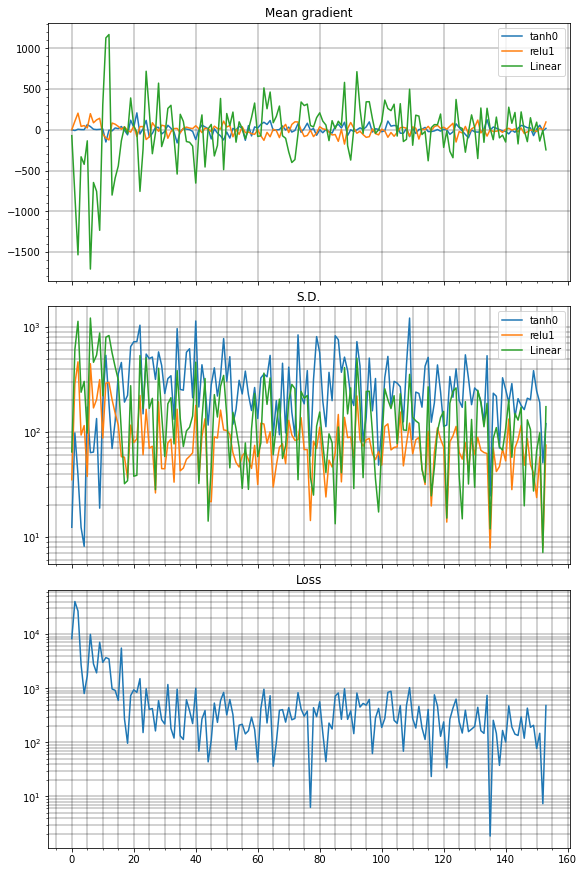

In [10]:
mArch = [[4, 'tanh', 1], [3, 'relu', 1]]
metrics=['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]
batch_size = BS
n_epochs = EPOCHS
model = create_model(mArch)
model.summary()
model.compile(optimizer=optimizer, loss=loss_fn,metrics=metrics)
gradhistory, losshistory, bmodel = train_model(xtrain.values, ytrain.values,xval.values,yval.values, model,n_epochs=n_epochs,patience = 100)
plot_gradient(gradhistory, losshistory)

1/1 [==============================] - 0s 18ms/step


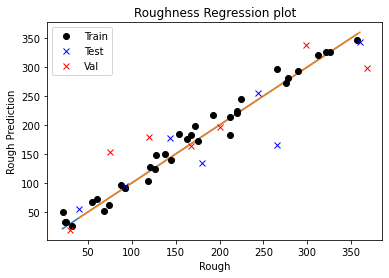

In [11]:
ypredtr =  bmodel.predict(xtrain).squeeze()
ypredte =  bmodel.predict(xtest).squeeze()
ypredva =  bmodel.predict(xval).squeeze()

plt.plot(ytrain,ytrain)
plt.plot(ytest,ytest)
plt.plot(ytrain,ypredtr,'ko',label='Train')
plt.plot(ytest,ypredte,'bx',label='Test') 
plt.plot(yval,ypredva,'rx',label='Val')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')
plt.title('Roughness Regression plot')
plt.show()

In [12]:
bmodel.evaluate(xtrain,ytrain,verbose=1)
bmodel.evaluate(xtest,ytest,verbose=1)
print('ok')

1/1 [==============================] - 0s 26ms/step - loss: 1950.3005 - mean_squared_error: 1950.3005 - mean_absolute_error: 31.8951 - mean_absolute_percentage_error: 19.4395
ok


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tanh0 (Dense)               (None, 4)                 32        
                                                                 
 tanh1 (Dense)               (None, 3)                 15        
                                                                 
 Linear (Dense)              (None, 1)                 4         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
At Epoch 0 validation loss improved to: inf after 0 idle epochs
At Epoch 1 validation loss improved to: 42739.3046875 after 1 idle epochs
At Epoch 2 validation loss improved to: 41850.54296875 after 1 idle epochs
At Epoch 3 validation loss improved to: 41038.9453125 after 1 idle epochs
At Epoch 4 validation loss improved

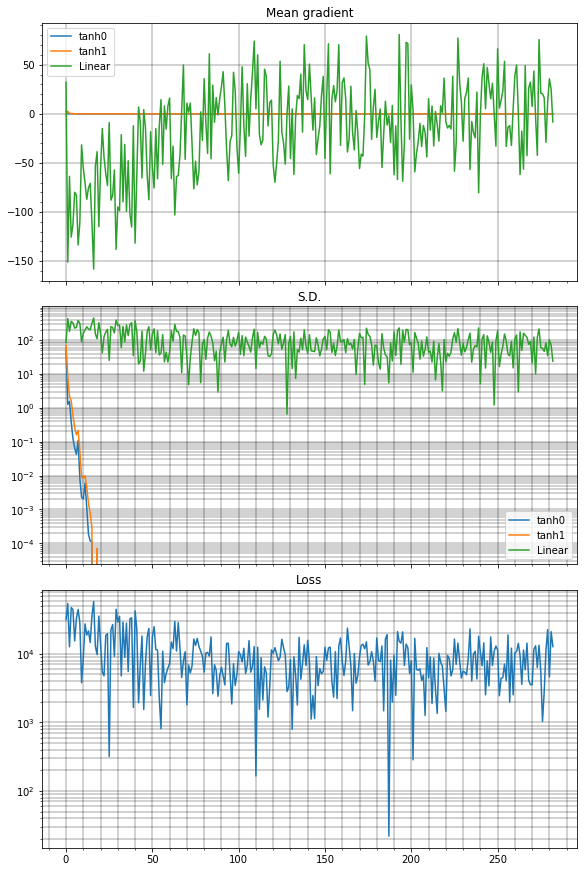

In [13]:
mArch = [[4, 'tanh', 1], [3, 'tanh', 1]]
metrics=['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]
batch_size = BS
n_epochs = EPOCHS
model2 = create_model(mArch)
model2.summary()
model2.compile(optimizer=optimizer, loss=loss_fn,metrics=metrics)
gradhistory2, losshistory2, bmodel2= train_model(xtrain.values,ytrain.values,xval.values,yval.values, model2,n_epochs=n_epochs,patience = 50)
plot_gradient(gradhistory2, losshistory2)

1/1 [==============================] - 0s 18ms/step


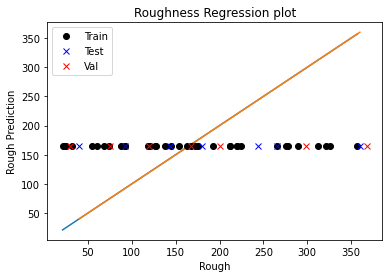

In [14]:
ypredtr =  bmodel2.predict(xtrain).squeeze()
ypredte =  bmodel2.predict(xtest).squeeze()
ypredva =  bmodel2.predict(xval).squeeze()

plt.plot(ytrain,ytrain)
plt.plot(ytest,ytest)
plt.plot(ytrain,ypredtr,'ko',label='Train')
plt.plot(ytest,ypredte,'bx',label='Test') 
plt.plot(yval,ypredva,'rx',label='Val')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')
plt.title('Roughness Regression plot')
plt.show()

In [15]:
bmodel2.evaluate(xtrain,ytrain)
bmodel2.evaluate(xtest,ytest)
print('ok')

1/1 [==============================] - 0s 23ms/step - loss: 10829.7041 - mean_squared_error: 10829.7041 - mean_absolute_error: 86.8242 - mean_absolute_percentage_error: 77.0940
ok


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tanh0 (Dense)               (None, 4)                 32        
                                                                 
 elu1 (Dense)                (None, 3)                 15        
                                                                 
 Linear (Dense)              (None, 1)                 4         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
At Epoch 0 validation loss improved to: inf after 0 idle epochs
At Epoch 1 validation loss improved to: 41934.91796875 after 1 idle epochs
At Epoch 2 validation loss improved to: 37127.12890625 after 1 idle epochs
At Epoch 3 validation loss improved to: 32024.087890625 after 1 idle epochs
At Epoch 4 validation loss impro

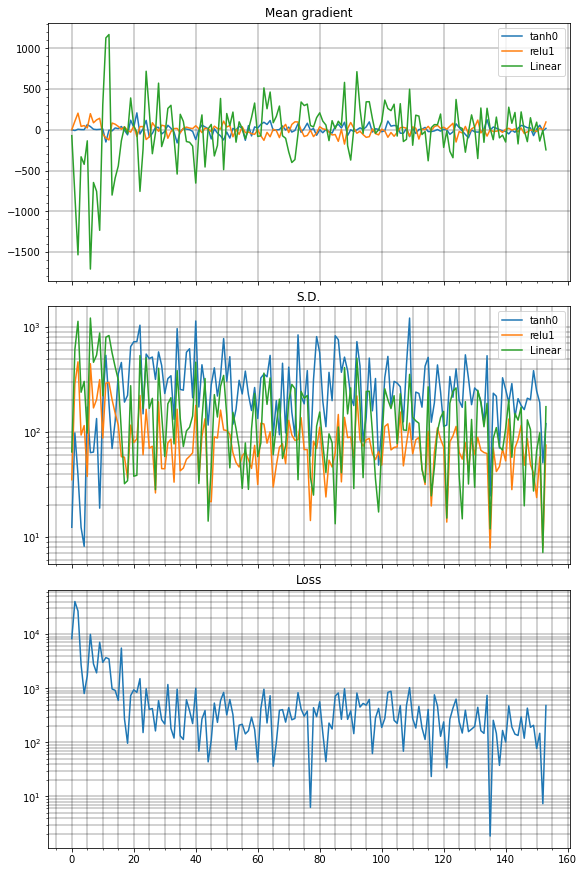

In [16]:
mArch = [[4, 'tanh', 1], [3, 'elu', 1]]
metrics=['mean_squared_error','mean_absolute_error',tf.keras.losses.MeanAbsolutePercentageError()]
batch_size = BS
n_epochs = EPOCHS
model3 = create_model(mArch)
model3.summary()
model3.compile(optimizer=optimizer, loss=loss_fn,metrics=metrics)
gradhistory3, losshistory3,bmodel3 = train_model(xtrain.values, ytrain.values,xval.values,yval.values, model3,n_epochs=n_epochs,patience =50)
plot_gradient(gradhistory, losshistory)

1/1 [==============================] - 0s 18ms/step


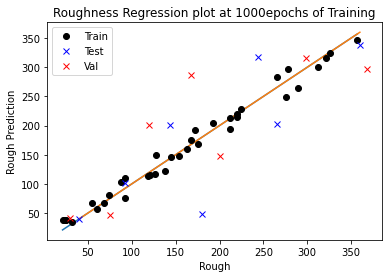

In [17]:
ypredtr =  bmodel3.predict(xtrain).squeeze()
ypredte =  bmodel3.predict(xtest).squeeze()
ypredva =  bmodel3.predict(xval).squeeze()

plt.plot(ytrain,ytrain)
plt.plot(ytest,ytest)
plt.plot(ytrain,ypredtr,'ko',label='Train')
plt.plot(ytest,ypredte,'bx',label='Test') 
plt.plot(yval,ypredva,'rx',label='Val')
plt.legend()
plt.xlabel(CASE)
plt.ylabel(CASE +' Prediction')
plt.title('Roughness Regression plot at ' + str(EPOCHS) + 'epochs of Training')
plt.show()

In [18]:
bmodel3.evaluate(xtrain,ytrain)
bmodel3.evaluate(xtest,ytest,verbose=1)
print('ok')

1/1 [==============================] - 0s 21ms/step - loss: 4327.0400 - mean_squared_error: 4327.0400 - mean_absolute_error: 50.8120 - mean_absolute_percentage_error: 26.3566
ok
